<a href="https://colab.research.google.com/github/Shekhawat34/Machine-Learning-Project/blob/main/3d_MRI_image_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## Load Brats2018 dataset

In [ ]:
!kaggle datasets download -d sanglequang/brats2018

import zipfile
zip_ref = zipfile.ZipFile('brats2018.zip', 'r')
zip_ref.extractall('/content/Brats_Data')
zip_ref.close()


Dataset URL: https://www.kaggle.com/datasets/sanglequang/brats2018
License(s): unknown
100% 3.17G/3.18G [00:27<00:00, 84.1MB/s]
100% 3.18G/3.18G [00:27<00:00, 122MB/s] 


## Define function to load HGG image of type flair from Brats Dataset

In [ ]:
!pip install nibabel
!pip install nilearn


import csv
import numpy as np
import torch
from torch.utils.data.dataset import Dataset
import os
import skimage.transform as transform
from nilearn import surface
import nibabel as nib
from skimage import exposure

class BRATSdataset(Dataset):
    def __init__(self, train=True, imgtype = 'flair', severity='HGG',is_flip=False,augmentation=True):
        self.augmentation = augmentation
        if train:
            self.root = '/content/Brats_Data/MICCAI_BraTS_2018_Data_Training/' + severity
        else:
            self.root = '/content/Brats_Data/MICCAI_BraTS_2018_Data_Validation'
        self.imgtype = imgtype
        list_img = os.listdir(self.root)
        list_img.sort()
        self.imglist = list_img
        self.is_flip = is_flip

    def __len__(self):
        return len(self.imglist)

    def __getitem__(self, index):

        path = os.path.join(self.root,self.imglist[index])

        img = nib.load(os.path.join(path,self.imglist[index]+'_'+self.imgtype+'.nii'))
        gt = nib.load(os.path.join(path,self.imglist[index])+'_'+'seg.nii')

        A = np.zeros((240,240,166))
        G = np.zeros((240,240,166))
        A[:,:,11:] = img.get_fdata()
        G[:,:,11:] = gt.get_fdata()
        x=[]
        y=[]
        z=[]

        for i in range(240):
            if np.all(A[i,:,:] ==0):
                x.append(i)
            if np.all(A[:,i,:]==0):
                y.append(i)
            if i <155:
                if np.all(A[:,:,i]==0):
                    z.append(i)

        xl,yl,zl = 0,0,0
        xh,yh,zh = 240,240,155
        for xn in x:
            if xn < 120:
                if xn> xl:
                    xl = xn
            else:
                if xn<xh:
                    xh = xn
        for yn in y:
            if yn < 120:
                if yn> yl:
                    yl = yn
            else:
                if yn<yh:
                    yh = yn
        for zn in z:
            if zn < 77:
                if zn> zl:
                    zl = zn
            else:
                if zn<zh:
                    zh = zn

        B = A[xl-10:xh+10,yl-10:yh+10,zl-10:zh+10]
        B = transform.resize(B, (128, 128, 128),mode='constant' )

        if self.is_flip:
            B = np.swapaxes(B,1,2)
            B = np.flip(B,1)
            B =np.flip(B,2)

        sp_size = 64
        img = transform.resize(B, (sp_size,sp_size,sp_size), mode='constant')
        if self.augmentation:
            random_n = torch.rand(1)
            random_i = 0.3*torch.rand(1)[0]+0.7
            if random_n[0] > 0.5:
                img = np.flip(img,0)

        img = 1.0*img
        img = exposure.rescale_intensity(img)
        img = (img-np.min(img))/(np.max(img)-np.min(img))
        img = 2*img-1

        imageout = torch.from_numpy(img).float().view(1,sp_size,sp_size,sp_size)

        return imageout

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 78.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from math import exp
import numpy as np
import scipy.ndimage as ndimage


def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()


def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    _3D_window = filters.gaussian_filter
    return window
def ssim_exact(img1, img2, sd=1.5, C1=0.01**2, C2=0.03**2):

    mu1 = ndimage.gaussian_filter(img1, sd)
    mu2 = ndimage.gaussian_filter(img2, sd)
    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = ndimage.gaussian_filter(img1 * img1, sd) - mu1_sq
    sigma2_sq = ndimage.gaussian_filter(img2 * img2, sd) - mu2_sq
    sigma12 = ndimage.gaussian_filter(img1 * img2, sd) - mu1_mu2

    ssim_num = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2))

    ssim_den = ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    ssim_map = ssim_num / ssim_den

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = np.mean(v1 / v2)  # contrast sensitivity



    return np.mean(ssim_map),cs

def ssim_3d(img1, img2, window_size=11, window=None, size_average=True, full=False, val_range=None):
    # Value range can be different from 255. Other common ranges are 1 (sigmoid) and 2 (tanh).
    if val_range is None:
        if torch.max(img1) > 128:
            max_val = 255
        else:
            max_val = 1

        if torch.min(img1) < -0.5:
            min_val = -1
        else:
            min_val = 0
        L = max_val - min_val
    else:
        L = val_range

    padd = 0
    (_, channel, height, width,width2) = img1.size()
    if window is None:
        real_size = min(window_size, height, width,width2)
        window = create_window(real_size, channel=channel).to(img1.device)

    mu1 = F.conv3d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv3d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv3d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv3d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv3d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs
    return ret


def msssim_3d(img1, img2, window_size=11, size_average=True, val_range=None, normalize=False):
    device = img1.device
    weights = torch.FloatTensor([0.0448, 0.2856, 0.3001, 0.2363, 0.1333]).to(device)
    levels = weights.size()[0]
    mssim = []
    mcs = []
    for _ in range(levels):
        sim, cs = ssim_exact(img1.data.cpu().numpy(), img2.data.cpu().numpy())
        mssim.append(sim)
        mcs.append(cs)

        img1 = F.avg_pool3d(img1, (2, 2,2))
        img2 = F.avg_pool3d(img2, (2, 2,2))

    mssim = np.asarray(mssim)
    mcs = np.asarray(mcs)
    # Normalize (to avoid NaNs during training unstable models, not compliant with original definition)
    if normalize:
        mssim = (mssim + 1) / 2
        mcs = (mcs + 1) / 2

    pow1 = mcs ** weights
    pow2 = mssim ** weights

    output = torch.prod(pow1[:-1] * pow2[-1])
    return output


# Classes to re-use window
class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True, val_range=None):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.val_range = val_range

        # Assume 1 channel for SSIM
        self.channel = 1
        self.window = create_window(window_size)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.dtype == img1.dtype:
            window = self.window
        else:
            window = create_window(self.window_size, channel).to(img1.device).type(img1.dtype)
            self.window = window
            self.channel = channel

        return ssim(img1, img2, window=window, window_size=self.window_size, size_average=self.size_average)

class MSSSIM_3d(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True, channel=3):
        super(MSSSIM_3d, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = channel

    def forward(self, img1, img2):

        return msssim_3d(img1, img2, window_size=self.window_size, size_average=self.size_average)

def ssim(img1, img2, window_size=11, window=None, size_average=True, full=False, val_range=None):
    # Value range can be different from 255. Other common ranges are 1 (sigmoid) and 2 (tanh).
    if val_range is None:
        if torch.max(img1) > 128:
            max_val = 255
        else:
            max_val = 1

        if torch.min(img1) < -0.5:
            min_val = -1
        else:
            min_val = 0
        L = max_val - min_val
    else:
        L = val_range

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs
    return ret


def msssim(img1, img2, window_size=11, size_average=True, val_range=None, normalize=False):
    device = img1.device
    weights = torch.FloatTensor([0.0448, 0.2856, 0.3001, 0.2363, 0.1333]).to(device)
    levels = weights.size()[0]
    mssim = []
    mcs = []
    for _ in range(levels):
        sim, cs = ssim(img1, img2, window_size=window_size, size_average=size_average, full=True, val_range=val_range)
        mssim.append(sim)
        mcs.append(cs)

        img1 = F.avg_pool2d(img1, (2, 2))
        img2 = F.avg_pool2d(img2, (2, 2))

    mssim = torch.stack(mssim)
    mcs = torch.stack(mcs)

    # Normalize (to avoid NaNs during training unstable models, not compliant with original definition)
    if normalize:
        mssim = (mssim + 1) / 2
        mcs = (mcs + 1) / 2

    pow1 = mcs ** weights
    pow2 = mssim ** weights

    output = torch.prod(pow1[:-1] * pow2[-1])
    return output


# Classes to re-use window
class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True, val_range=None):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.val_range = val_range

        # Assume 1 channel for SSIM
        self.channel = 1
        self.window = create_window(window_size)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.dtype == img1.dtype:
            window = self.window
        else:
            window = create_window(self.window_size, channel).to(img1.device).type(img1.dtype)
            self.window = window
            self.channel = channel

        return ssim(img1, img2, window=window, window_size=self.window_size, size_average=self.size_average)

class MSSSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True, channel=3):
        super(MSSSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = channel

    def forward(self, img1, img2):

        return msssim(img1, img2, window_size=self.window_size, size_average=self.size_average)



## Define Generative Adverserial Neural Network model (Discriminator and Generator)

In [ ]:
import numpy as np
import torch
import os
from torch import nn
from torch import optim
from torch.nn import functional as F

class Discriminator(nn.Module):
    def __init__(self, channel=512):
        super(Discriminator, self).__init__()
        self.channel = channel
        n_class = 1

        self.conv1 = nn.Conv3d(1, channel//8, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv3d(channel//8, channel//4, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm3d(channel//4)
        self.conv3 = nn.Conv3d(channel//4, channel//2, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm3d(channel//2)
        self.conv4 = nn.Conv3d(channel//2, channel, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm3d(channel)

        self.conv5 = nn.Conv3d(channel, n_class, kernel_size=4, stride=2, padding=1)

    def forward(self, x, _return_activations=False):
        h1 = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        h2 = F.leaky_relu(self.bn2(self.conv2(h1)), negative_slope=0.2)
        h3 = F.leaky_relu(self.bn3(self.conv3(h2)), negative_slope=0.2)
        h4 = F.leaky_relu(self.bn4(self.conv4(h3)), negative_slope=0.2)
        h5 = self.conv5(h4)
        output = h5

        return output


class MyGenerator(nn.Module):
    def __init__(self, noise:int=1000, channel:int=64):
        super(MyGenerator, self).__init__()
        _c = channel

        self.noise = noise
        self.fc = nn.Linear(1000,512*4*4*4)
        self.bn1 = nn.BatchNorm3d(_c*8)

        self.tp_conv2 = nn.Conv3d(_c*8, _c*4, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(_c*4)

        self.tp_conv3 = nn.Conv3d(_c*4, _c*2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm3d(_c*2)

        self.tp_conv4 = nn.Conv3d(_c*2, _c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm3d(_c)

        self.tp_conv5 = nn.Conv3d(_c, 1, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, noise):
        noise = noise.view(-1, 1000)
        h = self.fc(noise)
        h = h.view(-1,512,4,4,4)
        h = F.relu(self.bn1(h))

        h = F.upsample(h,scale_factor = 2)
        h = self.tp_conv2(h)
        h = F.relu(self.bn2(h))

        h = F.upsample(h,scale_factor = 2)
        h = self.tp_conv3(h)
        h = F.relu(self.bn3(h))

        h = F.upsample(h,scale_factor = 2)
        h = self.tp_conv4(h)
        h = F.relu(self.bn4(h))

        h = F.upsample(h,scale_factor = 2)
        h = self.tp_conv5(h)

        h = F.tanh(h)

        return h

In [ ]:
%pylab inline
import numpy as np
import torch
import os

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader
from nilearn import plotting

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['exp']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Define Gradient penalty

In [ ]:

import numpy as np
import torch
from torch import nn, optim, autograd
from torch.autograd import Variable
from torch.utils.data import DataLoader
from nilearn import plotting
import nibabel as nib

BATCH_SIZE = 4
max_epoch = 100
lr = 0.0001
gpu = True
workers = 4
LAMBDA = 10
latent_dim = 1000


trainset = BRATSdataset(imgtype='flair')
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=workers)


D = Discriminator()
G = MyGenerator(noise=latent_dim)



# Optimizers for both Generator and Discriminator
g_optimizer = optim.Adam(G.parameters(), lr=lr)
d_optimizer = optim.Adam(D.parameters(), lr=lr)

# Gradient Penalty Calculation
def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(real_data.size(0), 1, 1, 1, 1)
    alpha = alpha.expand(real_data.size())


    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = Variable(interpolates, requires_grad=True)



    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]


    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Train the model

In [ ]:
import numpy as np
import torch
from torch.autograd import Variable
import nibabel as nib
from nilearn import plotting
import os


BATCH_SIZE = 4
TOTAL_ITER = 200000
latent_dim = 1000


real_y = Variable(torch.ones((BATCH_SIZE, 1)))
fake_y = Variable(torch.zeros((BATCH_SIZE, 1)))
loss_f = nn.BCELoss()

# Loss tracking
d_real_losses, d_fake_losses, d_losses, g_losses = [], [], [], []


checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/checkpoints/'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

start_iteration = 0  # To keep track of the starting iteration if resuming

# Load previous checkpoints if available
G_checkpoint = None
D_checkpoint = None

G_checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('G_W_iter')]
D_checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('D_W_iter')]

if G_checkpoint_files and D_checkpoint_files:

    latest_G_checkpoint = max(G_checkpoint_files, key=lambda x: int(x.split('iter')[1].split('.pth')[0]))
    latest_D_checkpoint = max(D_checkpoint_files, key=lambda x: int(x.split('iter')[1].split('.pth')[0]))

    G_checkpoint = os.path.join(checkpoint_dir, latest_G_checkpoint)
    D_checkpoint = os.path.join(checkpoint_dir, latest_D_checkpoint)

    # Extract the iteration number from the filename
    start_iteration = int(latest_G_checkpoint.split('iter')[1].split('.pth')[0])

    print(f"Resuming from iteration {start_iteration}...")


G = MyGenerator()
D = Discriminator()


if G_checkpoint and D_checkpoint:
    G.load_state_dict(torch.load(G_checkpoint))
    D.load_state_dict(torch.load(D_checkpoint))
    print(f"Loaded checkpoints: G - {G_checkpoint}, D - {D_checkpoint}")

# Optimizers
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
gen_load = iter(train_loader)



Resuming from iteration 2500...


<ipython-input-14-4e8914eba638>:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(G_checkpoint))
<ipython-input-14-4e8914eba638>:55: FutureWarni

Loaded checkpoints: G - /content/drive/MyDrive/Colab Notebooks/checkpoints/G_W_iter2500.pth, D - /content/drive/MyDrive/Colab Notebooks/checkpoints/D_W_iter2500.pth


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
for iteration in range(start_iteration, TOTAL_ITER):

    # Train Discriminator (D)

    for p in D.parameters():
        p.requires_grad = True

    # Get real images
    try:
        real_images = next(gen_load)
    except StopIteration:
        gen_load = iter(train_loader)
        real_images = next(gen_load)

    real_images = Variable(real_images)
    _batch_size = real_images.size(0)

    D.zero_grad()

    # Forward pass real images through D
    y_real_pred = D(real_images)
    d_real_loss = y_real_pred.mean()

    # Generate fake images
    noise = Variable(torch.randn((_batch_size, latent_dim, 1, 1, 1)))
    fake_images = G(noise)
    y_fake_pred = D(fake_images.detach())


    d_fake_loss = y_fake_pred.mean()


    gradient_penalty = calc_gradient_penalty(D, real_images.data, fake_images.data)

    # Total discriminator loss
    d_loss = -d_real_loss + d_fake_loss + gradient_penalty
    d_loss.backward()
    Wasserstein_D = d_real_loss - d_fake_loss

    d_optimizer.step()


    # Train Generator (G)

    for p in D.parameters():
        p.requires_grad = False  # Disable gradients for D

    for iters in range(5):
        G.zero_grad()

        # Generate fake images
        noise = Variable(torch.randn((_batch_size, latent_dim, 1, 1, 1)))
        fake_images = G(noise)

        # Forward pass fake images through D
        y_fake_g = D(fake_images)

        # Generator loss
        g_loss = -y_fake_g.mean()

        g_loss.backward()
        g_optimizer.step()


    # Logging and Visualization

    if iteration % 10 == 0:
        d_real_losses.append(d_real_loss.item())
        d_fake_losses.append(d_fake_loss.item())
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        print(f'[{iteration}/{TOTAL_ITER}] D: {d_loss.item():.3f}, '
              f'D_real: {d_real_loss.item():.3f}, D_fake: {d_fake_loss.item():.3f}, '
              f'G: {g_loss.item():.3f}')

        # Visualization of fake images
        fake_image_np = np.squeeze((0.5 * fake_images[0].data.cpu().numpy()) + 0.5)
        fake_image_nifti = nib.Nifti1Image(fake_image_np, affine=np.eye(4))
        plotting.plot_img(fake_image_nifti, title="Generated Fake Image")
        plotting.show()


    # Save Model Checkpoints

    if (iteration + 1) % 500 == 0:
        torch.save(G.state_dict(), os.path.join(checkpoint_dir, f'G_W_iter{iteration+1}.pth'))
        torch.save(D.state_dict(), os.path.join(checkpoint_dir, f'D_W_iter{iteration+1}.pth'))
        print(f"Checkpoint saved at iteration {iteration + 1}")


In [ ]:

gpu = True
workers = 4
BATCH_SIZE = 1



## Generator

## Load the trained model( 2500 iterations)

In [ ]:
G=MyGenerator(noise=1000)
G.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/checkpoints/G_W_iter2500.pth'))


<ipython-input-11-6155556fdcf3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/checkpoints/G_W_iter250

<All keys matched successfully>

## Fake Images - Slice Series Visualization

<ipython-input-7-b9ce4c5b4e0c>:61: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.upsample(h,scale_factor = 2)
<ipython-input-7-b9ce4c5b4e0c>:65: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.upsample(h,scale_factor = 2)
<ipython-input-7-b9ce4c5b4e0c>:69: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.upsample(h,scale_factor = 2)
<ipython-input-7-b9ce4c5b4e0c>:73: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.upsample(h,scale_factor = 2)


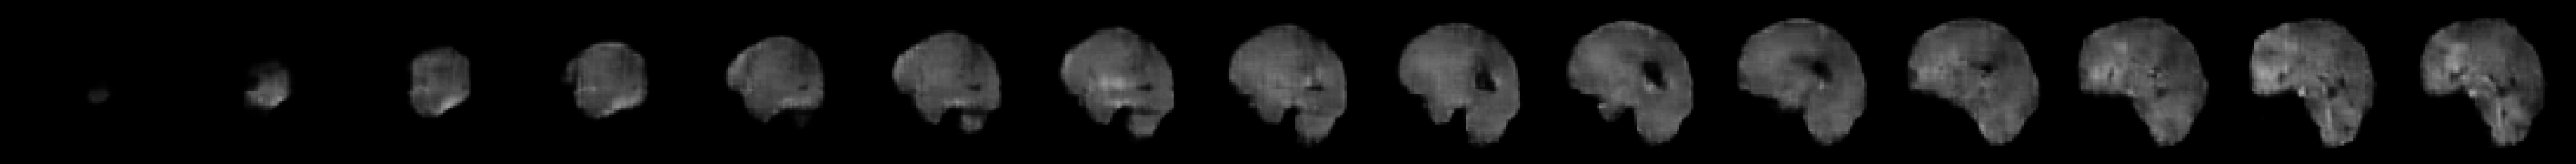

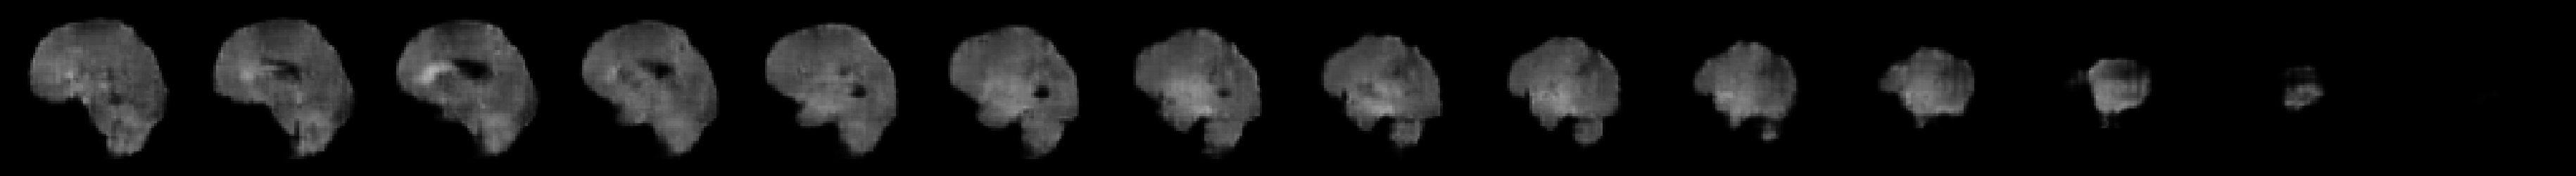

In [ ]:
Show_color = False

noise = Variable(torch.randn((1, 1000)))
fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))

arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]
if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

## Fake Image - Center cut slice visualization

<ipython-input-4-b9ce4c5b4e0c>:61: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.upsample(h,scale_factor = 2)
<ipython-input-4-b9ce4c5b4e0c>:65: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.upsample(h,scale_factor = 2)
<ipython-input-4-b9ce4c5b4e0c>:69: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.upsample(h,scale_factor = 2)
<ipython-input-4-b9ce4c5b4e0c>:73: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.upsample(h,scale_factor = 2)


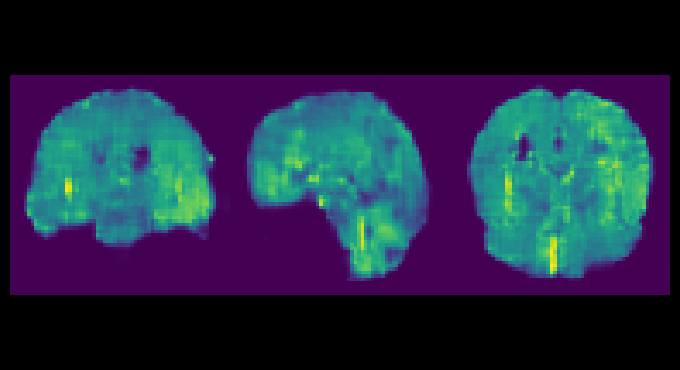

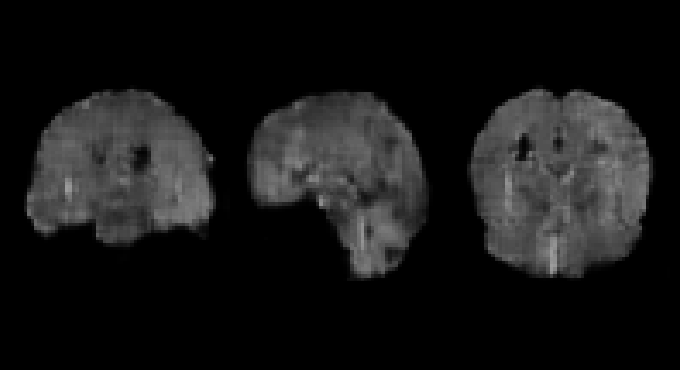

In [ ]:
noise = Variable(torch.randn((1, 1000)))
fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
plotting.plot_img(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.plot_anat(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.show()

## Save the Fake image with .png format

In [ ]:
noise = Variable(torch.randn((1, 1000)))
fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())


from PIL import Image
for i in range(64):
    A = 0.5*featmask[:,:,i]+0.5
    im = Image.fromarray(np.uint8(255*A)).convert("L")
    im.save('/content/drive/MyDrive/Colab Notebooks/Scan_Flair_images/Flair_img'+str(i)+'.png')

<ipython-input-4-b9ce4c5b4e0c>:61: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.upsample(h,scale_factor = 2)
<ipython-input-4-b9ce4c5b4e0c>:65: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.upsample(h,scale_factor = 2)
<ipython-input-4-b9ce4c5b4e0c>:69: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.upsample(h,scale_factor = 2)
<ipython-input-4-b9ce4c5b4e0c>:73: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.upsample(h,scale_factor = 2)


## Real Images -Slice Series Visualization

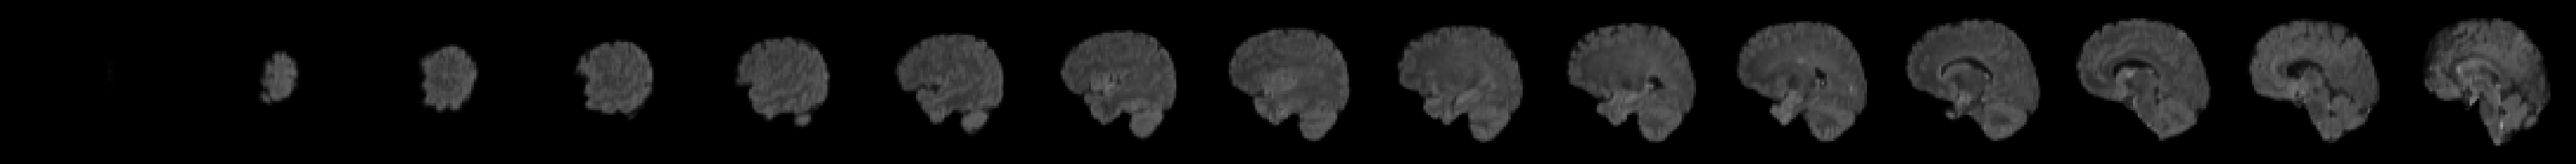

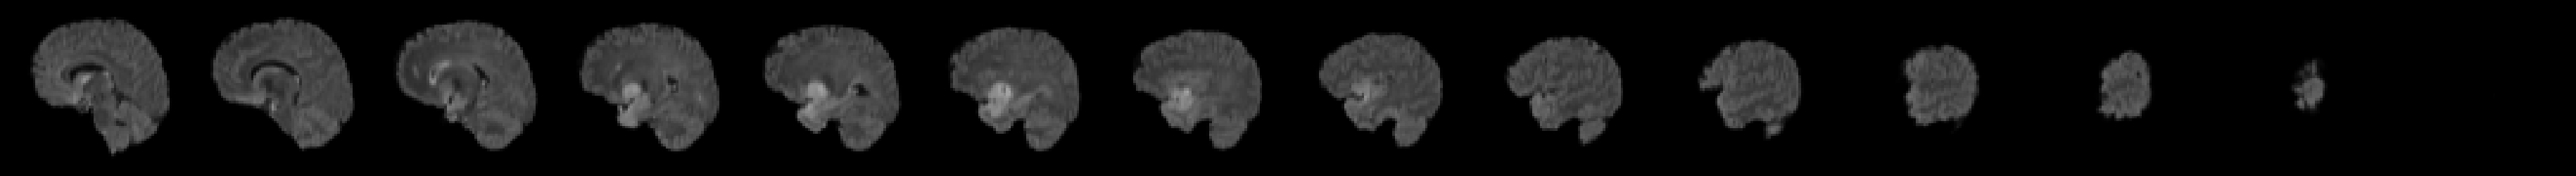

In [ ]:
Show_color = False


try:
    image = next(gen_load)
except StopIteration:
    gen_load = iter(train_loader)
    image = next(gen_load)

featmask = np.squeeze(image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]

if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')

    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')

    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

## Save the Real image with .png format

In [ ]:
image = next(gen_load)
featmask = np.squeeze(image[0].data.cpu().numpy())


from PIL import Image
for i in range(64):
    A = 0.5*featmask[:,:,i]+0.5
    im = Image.fromarray(np.uint8(255*A)).convert("L")
    im.save('/content/drive/MyDrive/Colab Notebooks/Scan_Flair_images/Real_image'+str(i)+'.png')

## Calculate sum_ssim for the real images

In [ ]:
sum_ssim = 0
for k in range(20):
    for i,dat in enumerate(train_loader):
        if len(dat)!=2:
            break
        img1 = dat[0]
        img2 = dat[1]

        msssim = msssim_3d(img1,img2)
        sum_ssim = sum_ssim+msssim
    print(sum_ssim/((k+1)*(i+1)))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


## ssim between the fake images

In [ ]:
import numpy as np
from skimage.metrics import structural_similarity as ssim


fake_image_0 = np.squeeze(fake_image[0].data.cpu().numpy())
fake_image_1 = np.squeeze(fake_image[1].data.cpu().numpy())


fake_image_0 = (fake_image_0 - fake_image_0.min()) / (fake_image_0.max() - fake_image_0.min())
fake_image_1 = (fake_image_1 - fake_image_1.min()) / (fake_image_1.max() - fake_image_1.min())


data_range = 1.0


similarity_index = ssim(fake_image_0, fake_image_1, data_range=data_range, multichannel=True)  # Use multichannel=True for color images

print(f'SSIM between fake images: {similarity_index:.4f}')


SSIM between fake images: 0.8627


## Similarity betweeen the original and the fake image.

In [ ]:
import numpy as np
from skimage.metrics import structural_similarity as ssim


real_image = np.squeeze(image[0].data.cpu().numpy())  # Adjust indexing based on your data structure


noise = Variable(torch.randn((1, 1000)))
fake_image = G(noise)

fake_image_0 = np.squeeze(fake_image[0].data.cpu().numpy())

real_image = (real_image - real_image.min()) / (real_image.max() - real_image.min())
fake_image_0 = (fake_image_0 - fake_image_0.min()) / (fake_image_0.max() - fake_image_0.min())


data_range = 1.0


similarity_index = ssim(real_image, fake_image_0, data_range=data_range, multichannel=True)

print(f'SSIM between real and fake images: {similarity_index:.4f}')


<ipython-input-7-b9ce4c5b4e0c>:61: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.upsample(h,scale_factor = 2)
<ipython-input-7-b9ce4c5b4e0c>:65: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.upsample(h,scale_factor = 2)
<ipython-input-7-b9ce4c5b4e0c>:69: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.upsample(h,scale_factor = 2)
<ipython-input-7-b9ce4c5b4e0c>:73: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.upsample(h,scale_factor = 2)


SSIM between real and fake images: 0.6317


## Check for the tumor inside the 3D generated images

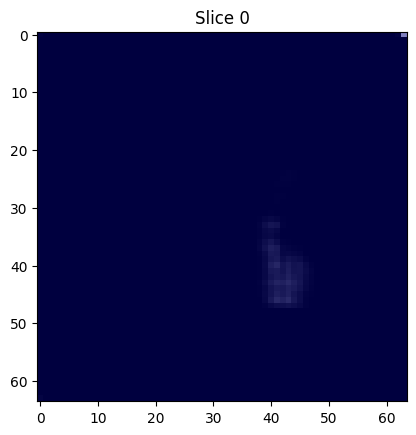

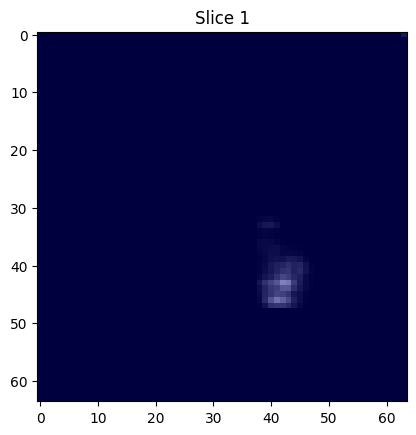

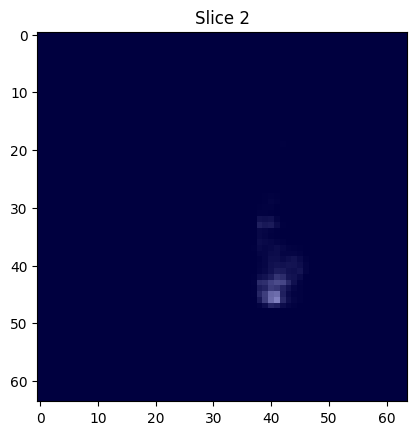

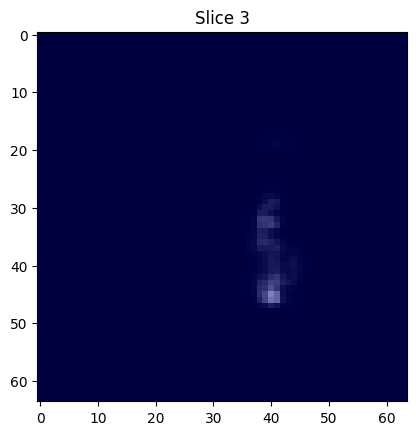

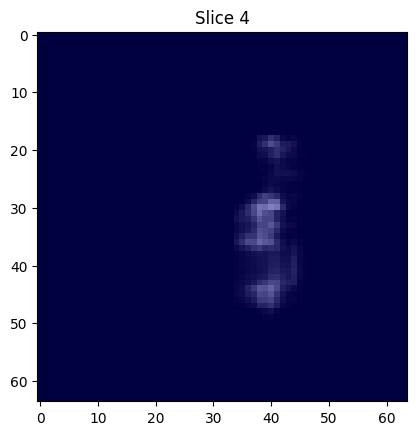

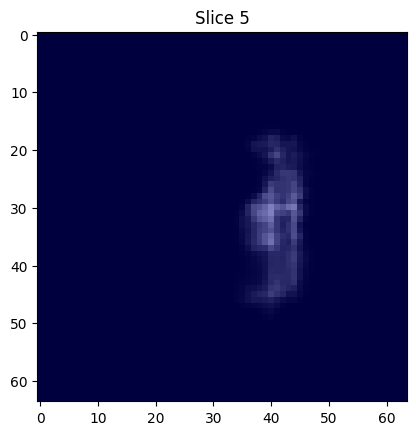

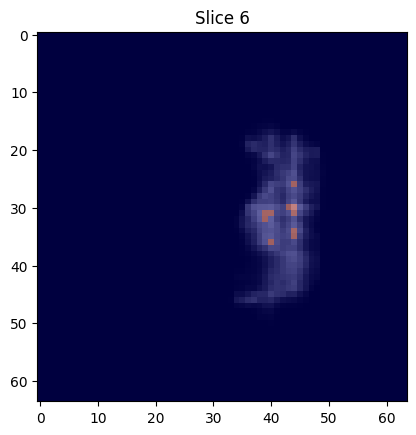

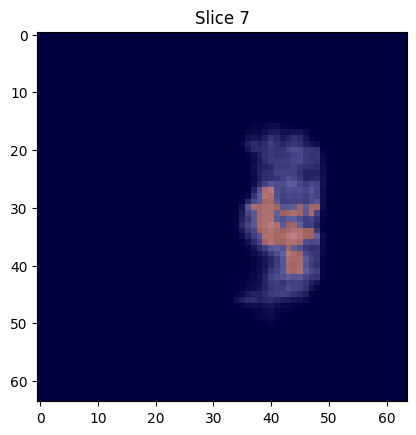

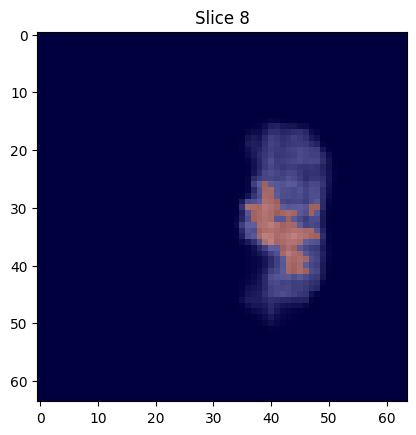

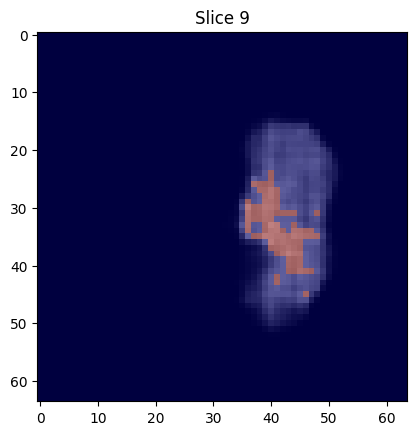

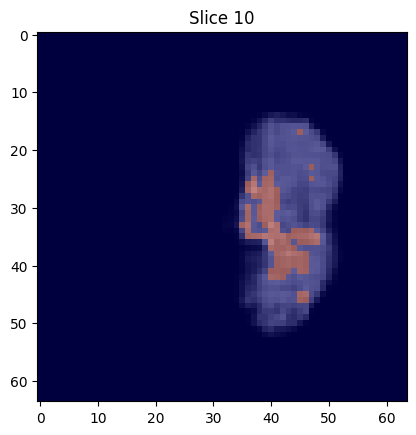

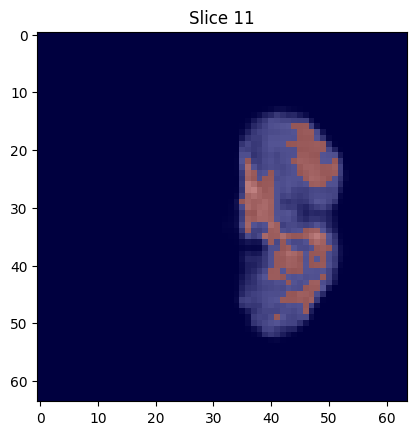

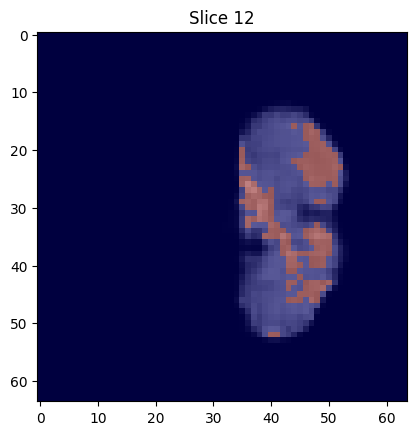

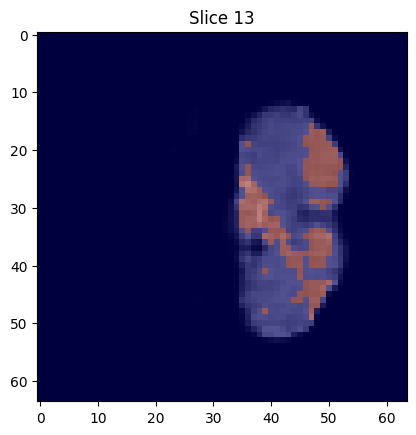

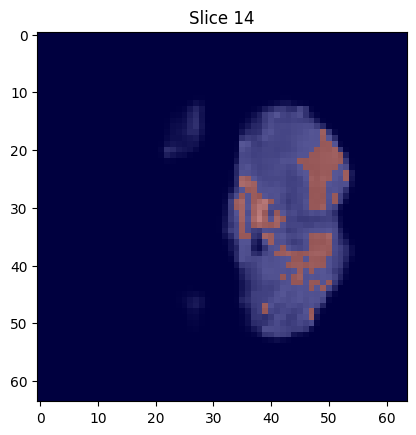

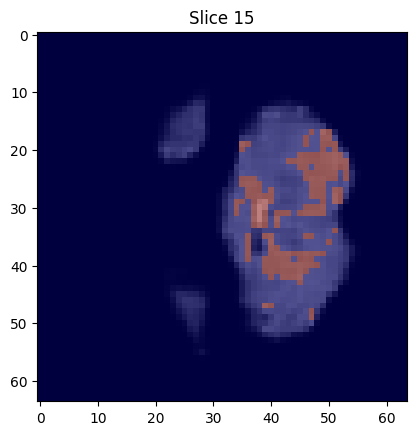

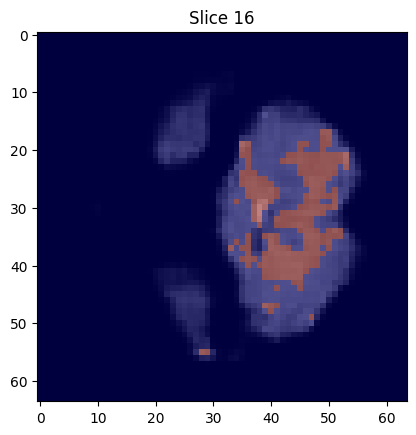

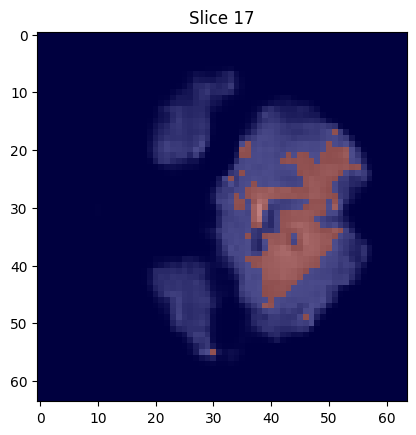

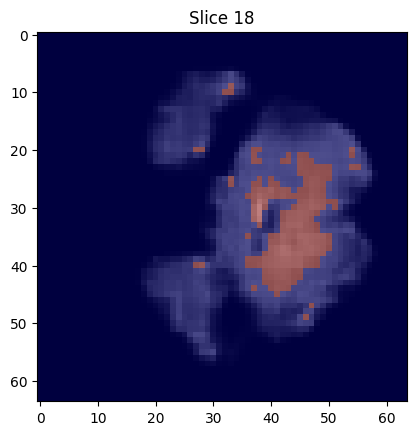

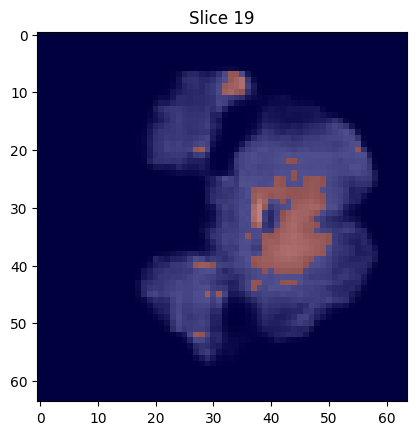

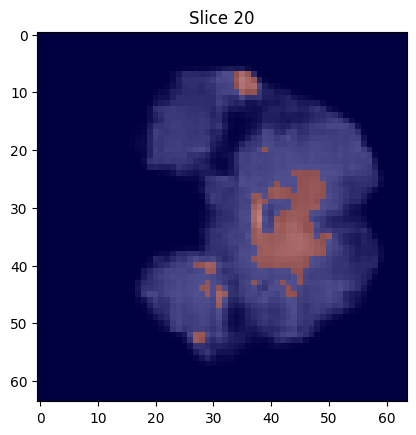

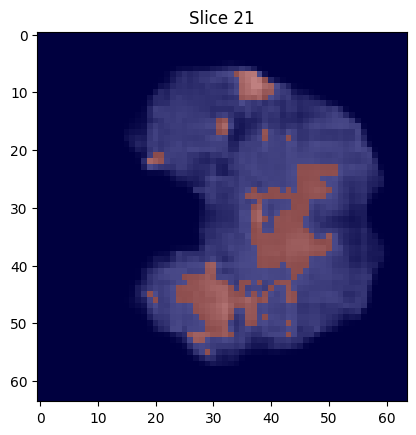

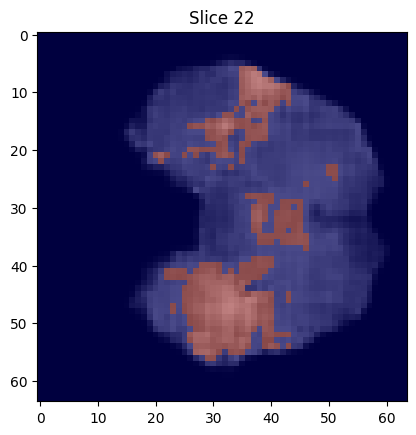

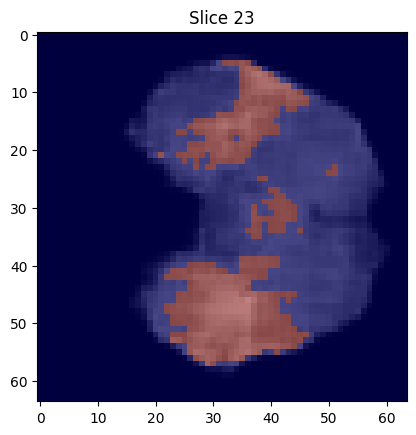

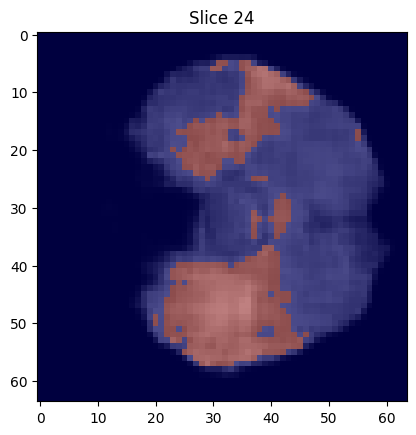

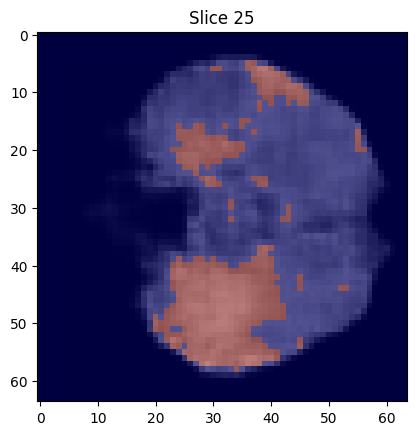

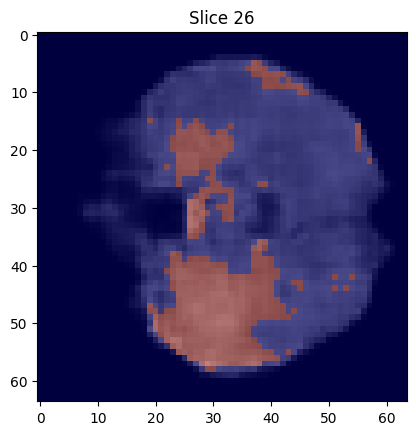

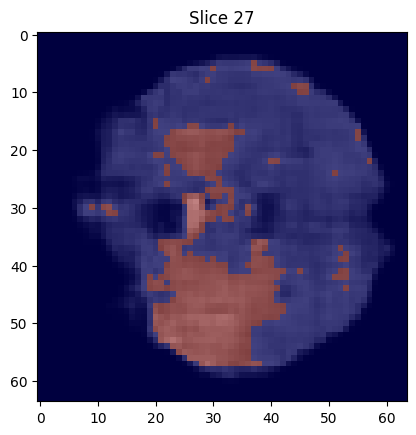

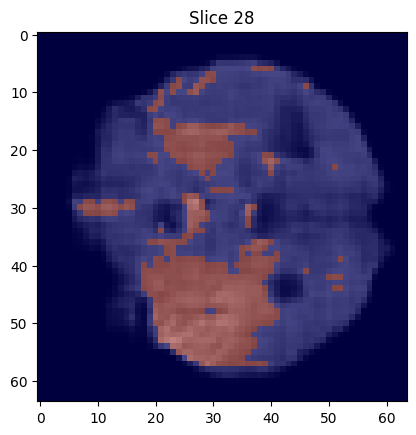

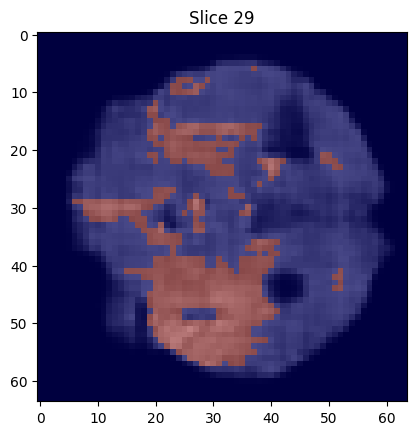

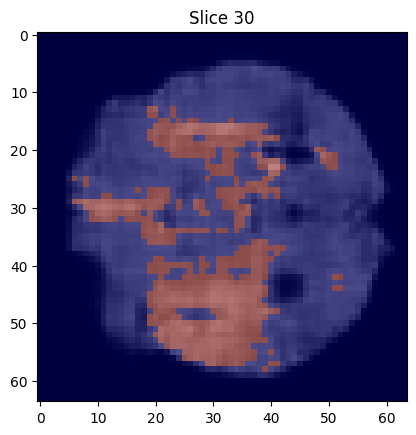

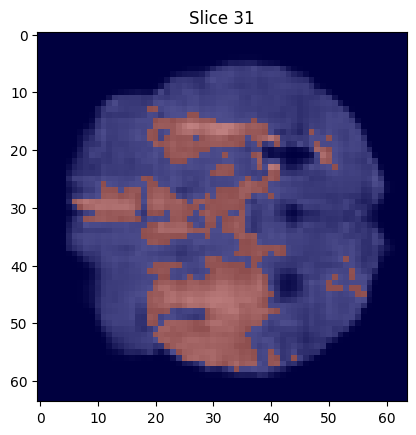

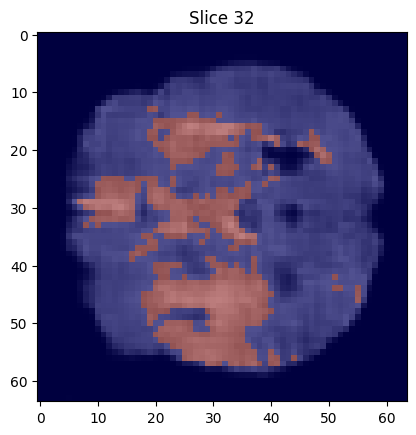

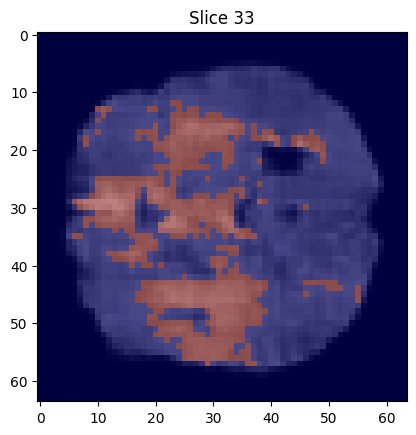

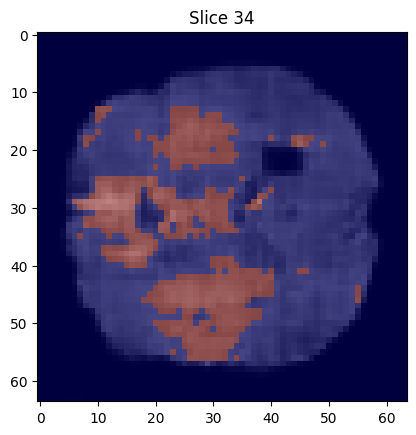

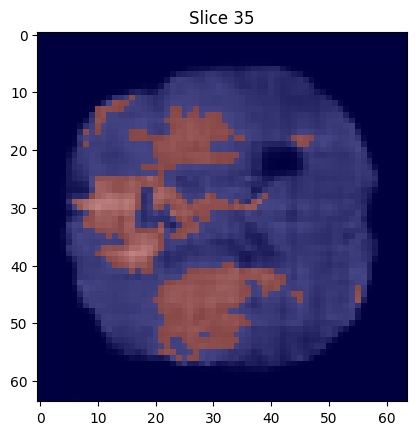

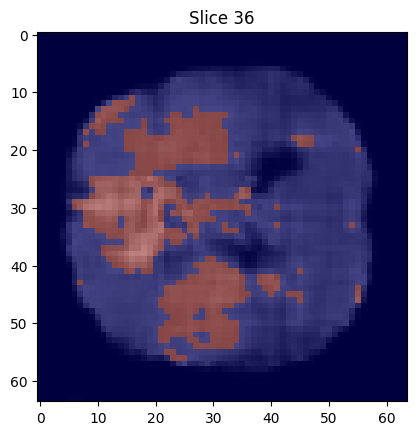

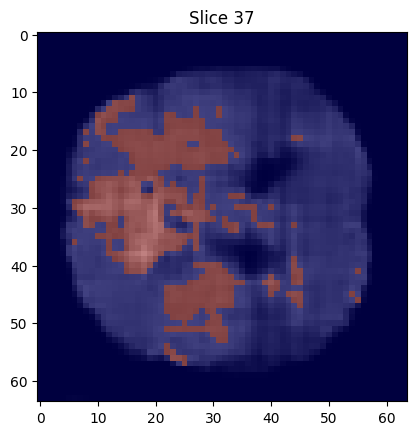

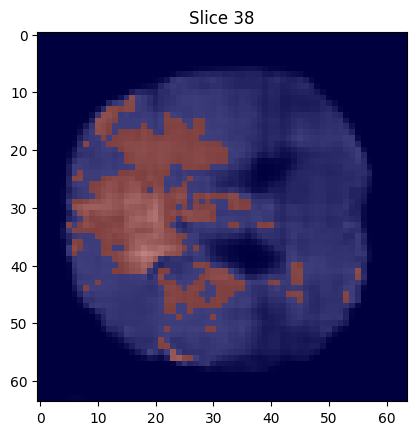

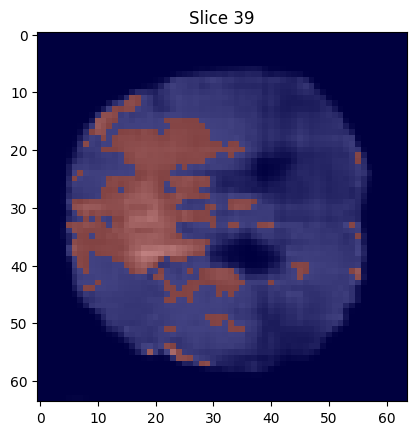

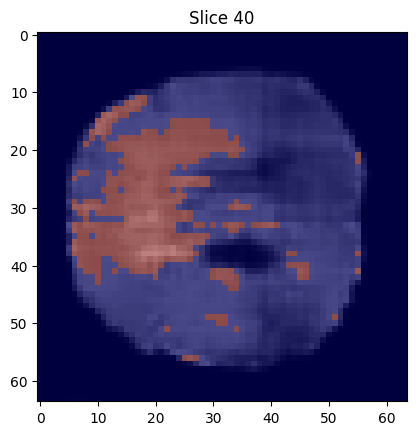

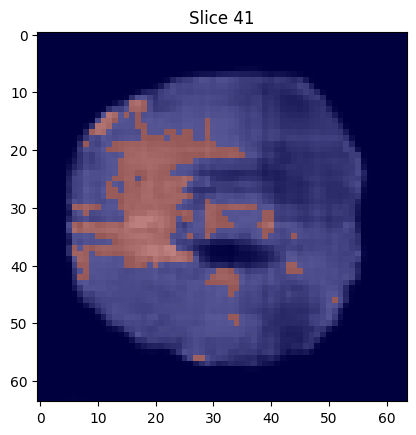

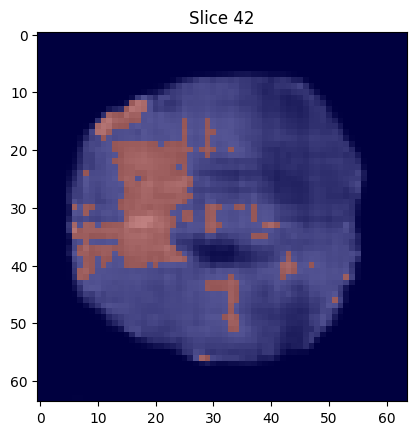

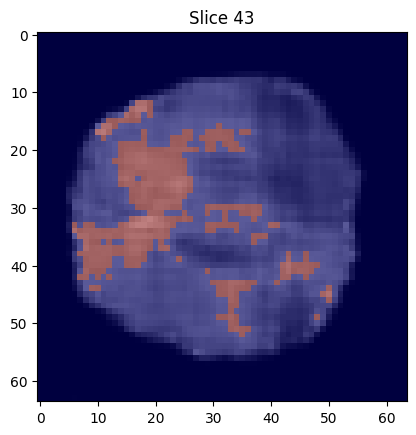

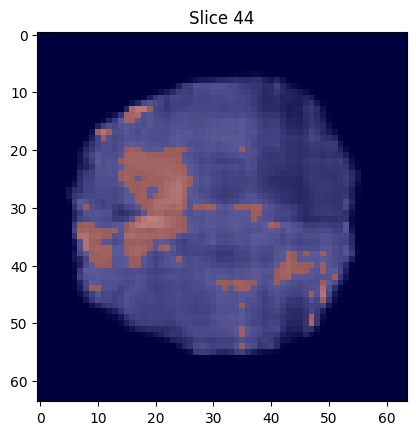

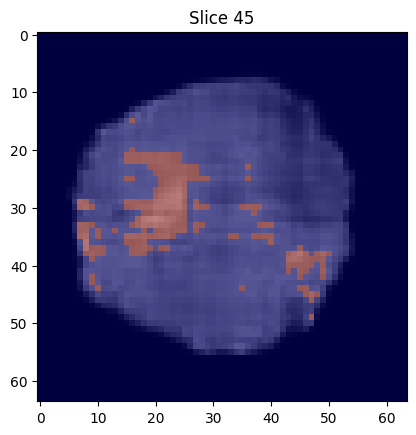

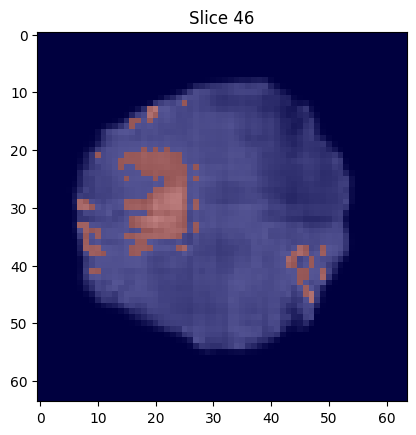

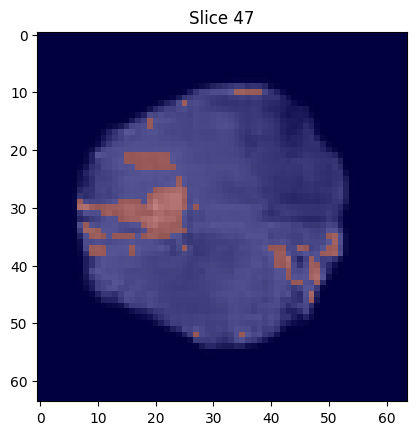

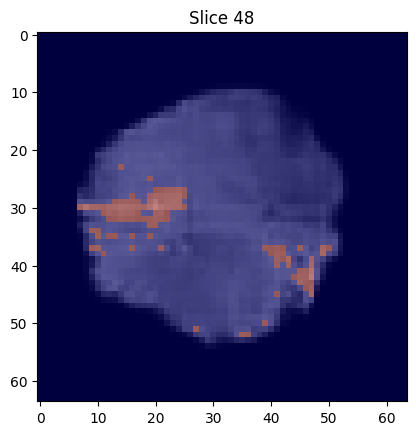

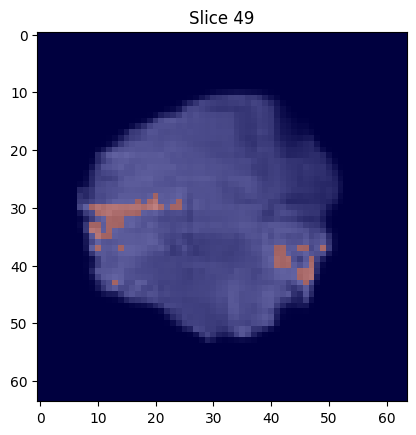

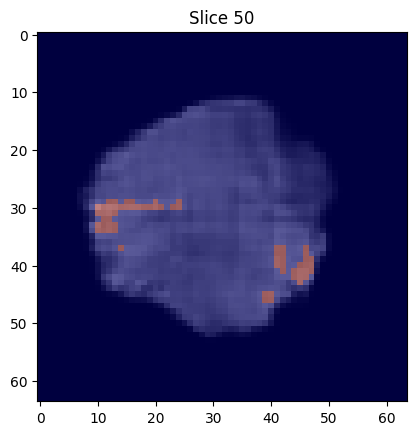

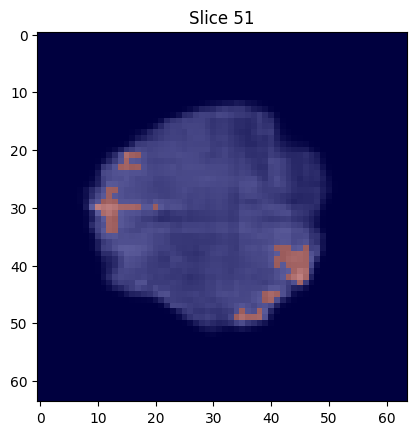

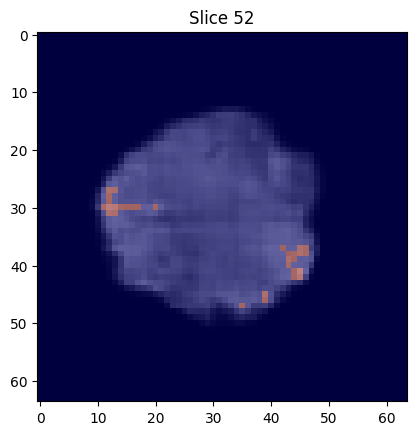

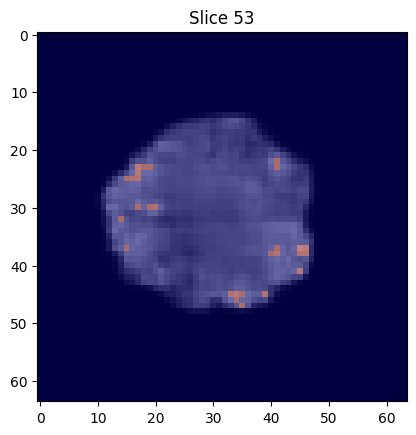

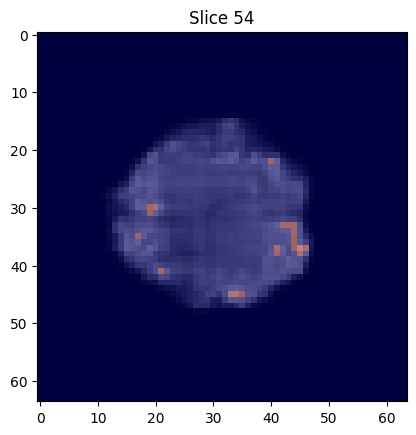

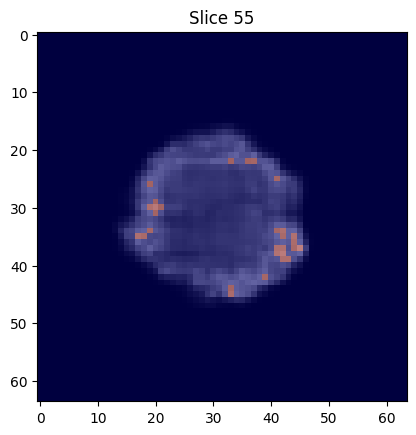

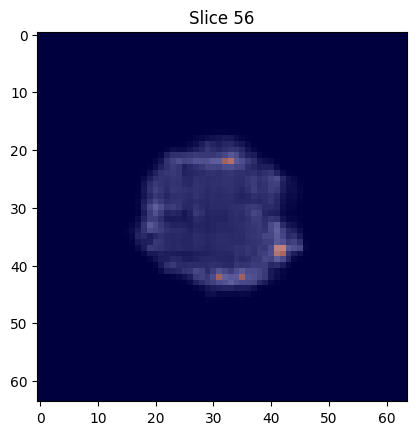

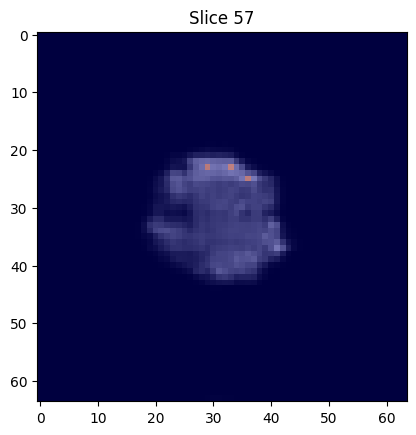

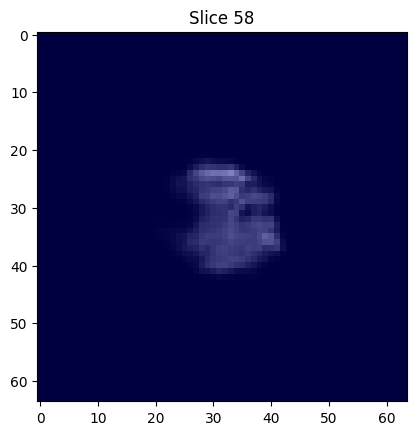

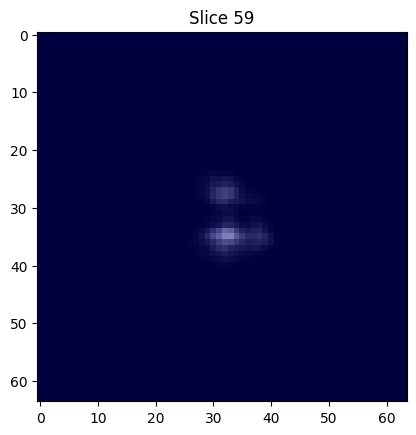

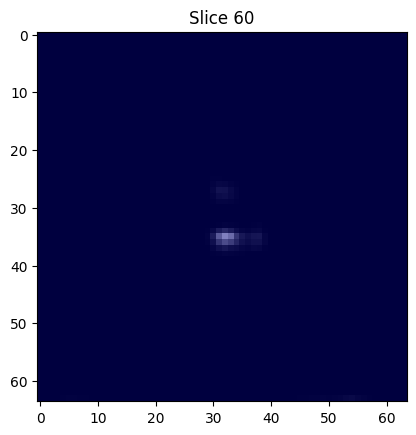

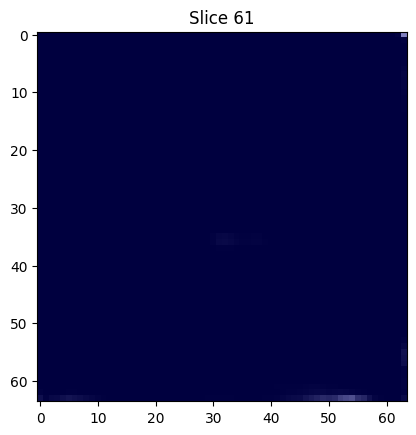

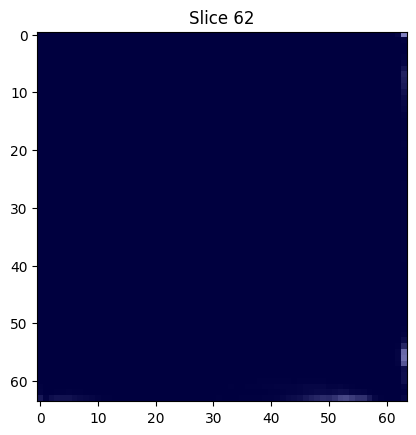

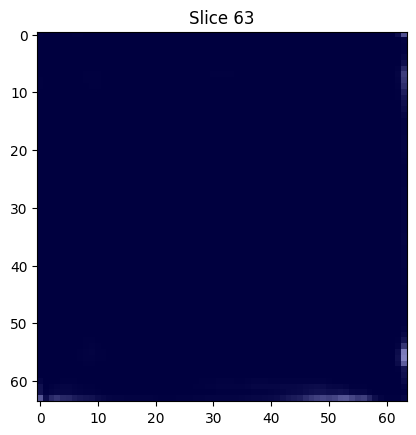

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


featmask = np.squeeze(fake_image[0].data.cpu().numpy())
normalized_image = (featmask - featmask.min()) / (featmask.max() - featmask.min())

tumor_threshold = 0.
tumor_mask = normalized_image > tumor_threshold  # Binary mask where tumor is present

for i in range(64):  # Assuming 64 slices in the z-axis
    plt.figure()
    plt.imshow(normalized_image[:, :, i], cmap='gray')  # Display the original image
    plt.imshow(tumor_mask[:, :, i], cmap='jet', alpha=0.5)  # Overlay the tumor mask in red with transparency
    plt.title(f'Slice {i}')
    plt.show()

## Segment the tumor

In [ ]:
# Apply simple thresholding or other segmentation method (if required)
# Tumor region will have values of 1, rest of the image will be 0
tumor_mask = (normalized_image > tumor_threshold).astype(np.uint8)


## Calculate tumor volume of tumor

In [ ]:

voxel_volume_mm3 = 1.0


tumor_voxel_count = np.sum(tumor_mask)

# Calculate the total tumor volume
tumor_volume = tumor_voxel_count * voxel_volume_mm3  # Volume in mm³

# Convert to cm³ if needed
tumor_volume_cm3 = tumor_volume / 1000.0  # Convert to cubic centimeters (cm³)

print(f"Tumor volume: {tumor_volume_cm3:.2f} cm³")


Tumor volume: 16.10 cm³
